## Descargar datos

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from datetime import date
from datetime import datetime as fechas
import matplotlib.pyplot as plt
import statistics as st
import matplotlib.dates as mdates
import locale
import matplotlib as mpl
from pylab import rcParams
from matplotlib.ticker import MultipleLocator

ruta = 'C:/Users/Asus/Documents/Python/Databases/'

df_dead = pd.read_csv(ruta + "bdmuertos.csv", parse_dates=['FECHA'], encoding='latin')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Parametros fecha

In [2]:
ultimo_martes = '08-04-2020' #ultimo martes mm-dd-yyyy

## Procesar

In [3]:
df_ded = df_dead[df_dead['MUERTE VIOLENTA']=='SIN REGISTRO']
df_ded['concat'] = df_ded['DEBIDO A (CAUSA A)'] + df_ded['DEBIDO A (CAUSA B)'] + df_ded['DEBIDO A (CAUSA C)']
df_ded['concat'] = df_ded['concat'] + df_ded['DEBIDO A (CAUSA D)'] + df_ded['DEBIDO A (CAUSA E)'] + df_ded['DEBIDO A (CAUSA F)']

#creando dummies para caso, sospecha, domicilio e institucion
df_ded['COVID'] = 0
df_ded['COVID'][(df_ded['concat'].astype(str).str.contains('COV ')) | (df_ded['concat'].astype(str).str.contains('CORONAVIRUS')) | (df_ded['concat'].astype(str).str.contains('COV-')) | (df_ded['concat'].astype(str).str.contains('COVID')) ] = 1

df_ded['COVID_SOSP'] = 0
df_ded['COVID_SOSP'][(df_ded['COVID']==1)&((df_ded['concat'].astype(str).str.contains(' NO ')) | (df_ded['concat'].astype(str).str.contains('PROBABLE')) | (df_ded['concat'].astype(str).str.contains('SOSPECH')) | (df_ded['concat'].astype(str).str.contains('DESCAR'))) ] = 1

df_ded['COVID_CONF'] = 0
df_ded['COVID_CONF'][df_ded['COVID'] == 1] = 1
df_ded['COVID_CONF'][df_ded['COVID_SOSP'] == 1] = 0

df_ded['EXCOVID'] = 1
df_ded['EXCOVID'][df_ded['COVID']== 1] = 0

#truncando base a domicilio o establecimientos de salud
df_ded = df_ded[(df_dead['TIPO LUGAR']=='DOMICILIO') | (df_dead['TIPO LUGAR']=='EESS')]

df_ded['DOMICILIO'] = 0
df_ded['DOMICILIO'][df_ded['TIPO LUGAR']=='DOMICILIO']=1

df_ded['EESS'] = 0
df_ded['EESS'][df_ded['TIPO LUGAR']=='EESS']=1

#crenaod columnas de 4
df_ded['COVID_DOMICILIO'] = df_ded['COVID'] * df_ded['DOMICILIO']
df_ded['COVID_EESS'] = df_ded['COVID'] * df_ded['EESS']

df_ded['EXCOVID_DOMICILIO'] = df_ded['EXCOVID'] * df_ded['DOMICILIO']
df_ded['EXCOVID_EESS'] = df_ded['EXCOVID'] * df_ded['EESS']

#chancando base
df_casos = df_ded.groupby('FECHA').sum().reset_index()
df_casos = df_casos[['FECHA','COVID', 'COVID_CONF', 'COVID_SOSP' ,'EXCOVID','COVID_DOMICILIO','COVID_EESS','EXCOVID_DOMICILIO','EXCOVID_EESS']]
df_casos = df_casos.sort_values('FECHA')

#truncando fecha
# df_casos = df_casos[df_casos['FECHA'] >= '01-01-2020'] #es miercoles
df_casos = df_casos[df_casos['FECHA'] <= ultimo_martes] #ultimo martes mm-dd-yyyy
df_casos = df_casos.reset_index()


#Semanal
Vars = ['COVID','COVID_CONF','COVID_SOSP','EXCOVID','COVID_DOMICILIO',
        'COVID_EESS','EXCOVID_DOMICILIO','EXCOVID_EESS']


casos_weekly = {}
casos_weekly['FECHA'] = []

for año in ['2017','2018','2019']:
    casos_weekly['EXCOVID_'+año] = []

for var in Vars:
    casos_weekly[var] = []

window = 7

d1 = fechas.strptime('2020-01-01', "%Y-%m-%d")
d2 = fechas.strptime(ultimo_martes, "%m-%d-%Y")
diff = int(((d2 - d1).days + 1) / 7)

for i in range(0,diff):
    #print(i)
    for año in ['2017','2018','2019']:
        fecha_ini_week = fechas.strptime(año+'-01-01', "%Y-%m-%d")+datetime.timedelta(days=i*7)
        casos_weekly['EXCOVID_'+año].append(sum(df_casos['EXCOVID'][(df_casos['FECHA'] >= fecha_ini_week) & (df_casos['FECHA'] < fecha_ini_week+datetime.timedelta(days=6))]))

    fecha_ini = fechas.strptime('2020-01-01', "%Y-%m-%d") + datetime.timedelta(days=(i+1)*7)
    casos_weekly['FECHA'].append(fecha_ini - datetime.timedelta(days=1))
    for var in Vars:
        casos_weekly[var].append(sum(df_casos[var][(df_casos['FECHA'] >= fecha_ini - datetime.timedelta(days=7) ) & (df_casos['FECHA'] < fecha_ini)]))

df_casos_weekly = pd.DataFrame(casos_weekly)               
                                 
#truncando para el diario
df_casos = df_casos[df_casos['FECHA'] >= '02-26-2020'].reset_index() #es miercoles

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

## Parametros graficos

In [4]:
firma = False
mensaje_1 = "Al 04 de agosto"
mensaje_2 = "Fuente: SINADEF al 08/08"

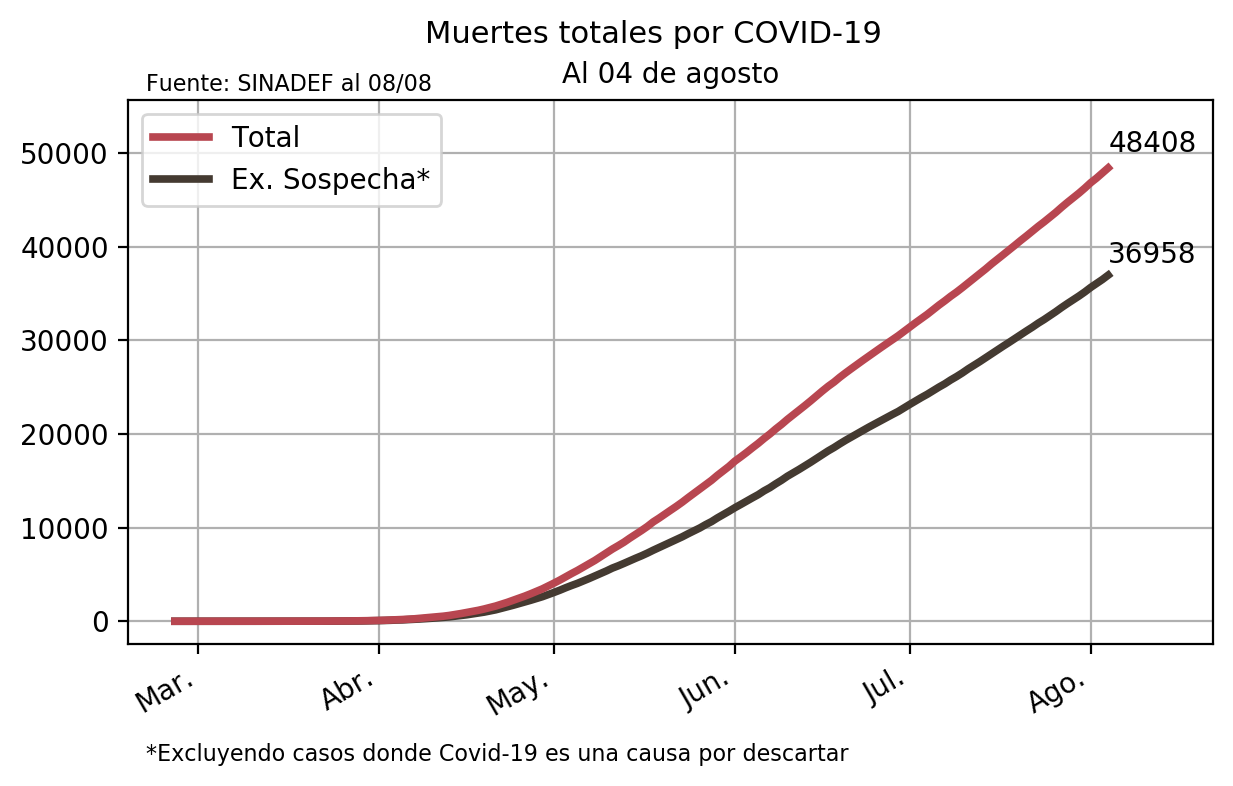

In [5]:
df_casos['CASO_acumulado'] = np.cumsum(df_casos['COVID'])
df_casos['CONF_acumulado'] = np.cumsum(df_casos['COVID_CONF'])

rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)


plt.plot(df_casos['FECHA'], df_casos['CASO_acumulado'],color=(184/255, 70/255, 80/255),linewidth=2.75, label='Total', zorder=3);
plt.plot(df_casos['FECHA'], df_casos['CONF_acumulado'],color=(68/255, 58/255, 49/255),linewidth=2.75, label='Ex. Sospecha*', zorder=2);
plt.gcf().autofmt_xdate()

plt.legend(loc=2)
plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)
plt.grid(zorder=0)
plt.title(mensaje_1, size=10)
plt.suptitle('Muertes totales por COVID-19', size=11)

maximo = df_casos['CASO_acumulado'].max()
fecha_ini = '21-02-2020'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.21, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '30-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.21, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), -13000, '*Excluyendo casos donde Covid-19 es una causa por descartar',
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

plt.text(df_casos['FECHA'][len(df_casos)-1], df_casos['CASO_acumulado'].max()*1.035, df_casos['CASO_acumulado'].max(), zorder=3)
plt.text(df_casos['FECHA'][len(df_casos)-1], df_casos['CONF_acumulado'].max()*1.035, df_casos['CONF_acumulado'].max(), zorder=3)
plt.ylim(top=df_casos['CASO_acumulado'].max()*1.15)
plt.xlim(right=df_casos['FECHA'][len(df_casos)-1]+datetime.timedelta(days=18))


plt.show()

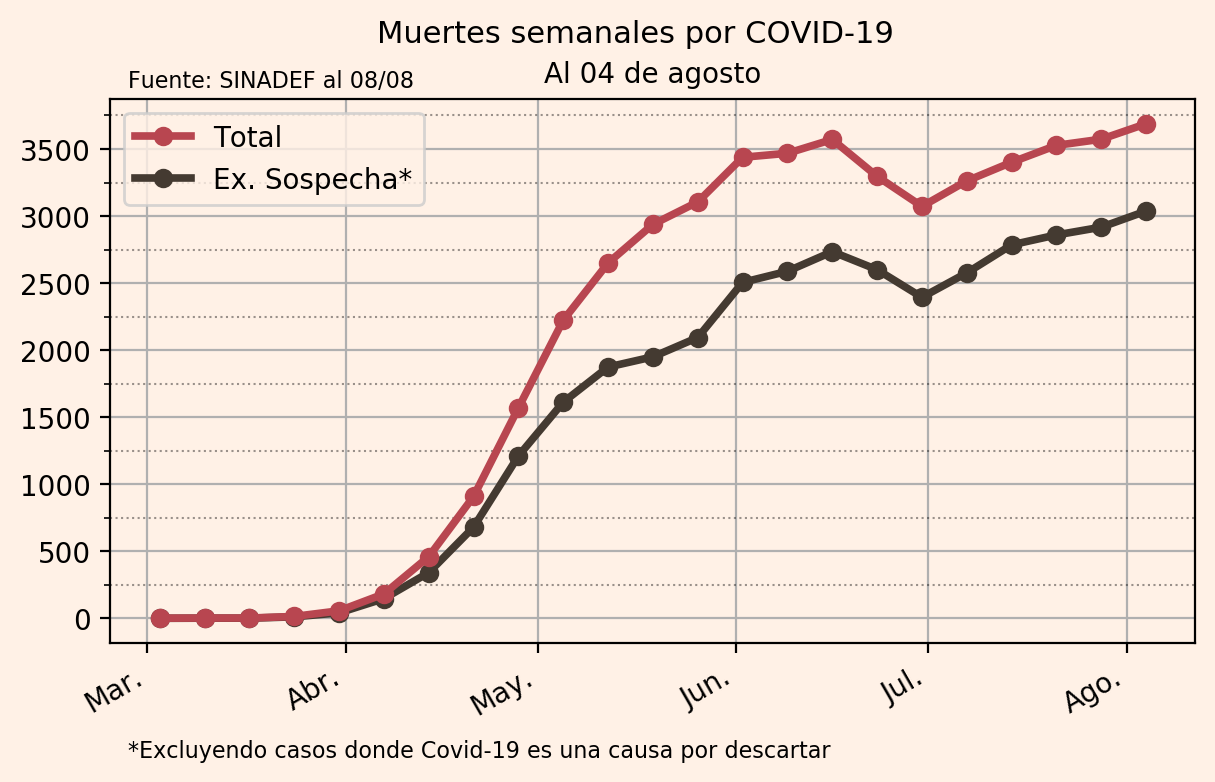

In [6]:
rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#truncando fecha
df_casos_weekly_2 = df_casos_weekly[df_casos_weekly['FECHA'] >= '03-01-2020'] #es domingo

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)


plt.plot(df_casos_weekly_2['FECHA'], df_casos_weekly_2['COVID'], marker="o", color=(184/255, 70/255, 80/255),linewidth=2.75, label='Total', zorder=3);
plt.plot(df_casos_weekly_2['FECHA'], df_casos_weekly_2['COVID_CONF'], marker="o", color=(68/255, 58/255, 49/255),linewidth=2.75, label='Ex. Sospecha*', zorder=2);
plt.gcf().autofmt_xdate()

plt.legend(loc=2)
plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)
plt.grid(zorder=0)
plt.title(mensaje_1, size=10)
plt.suptitle('Muertes semanales por COVID-19', size=11)

maximo = df_casos_weekly_2['COVID'].max()
fecha_ini = '27-02-2020'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.11, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '24-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.11, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), -900, '*Excluyendo casos donde Covid-19 es una causa por descartar',
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

plt.gca().yaxis.set_major_locator(MultipleLocator(500))
plt.gca().yaxis.set_minor_locator(MultipleLocator(250))
# plt.grid(zorder=2, alpha=0.8,linestyle=':',color='k',which='major')
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)

plt.show()

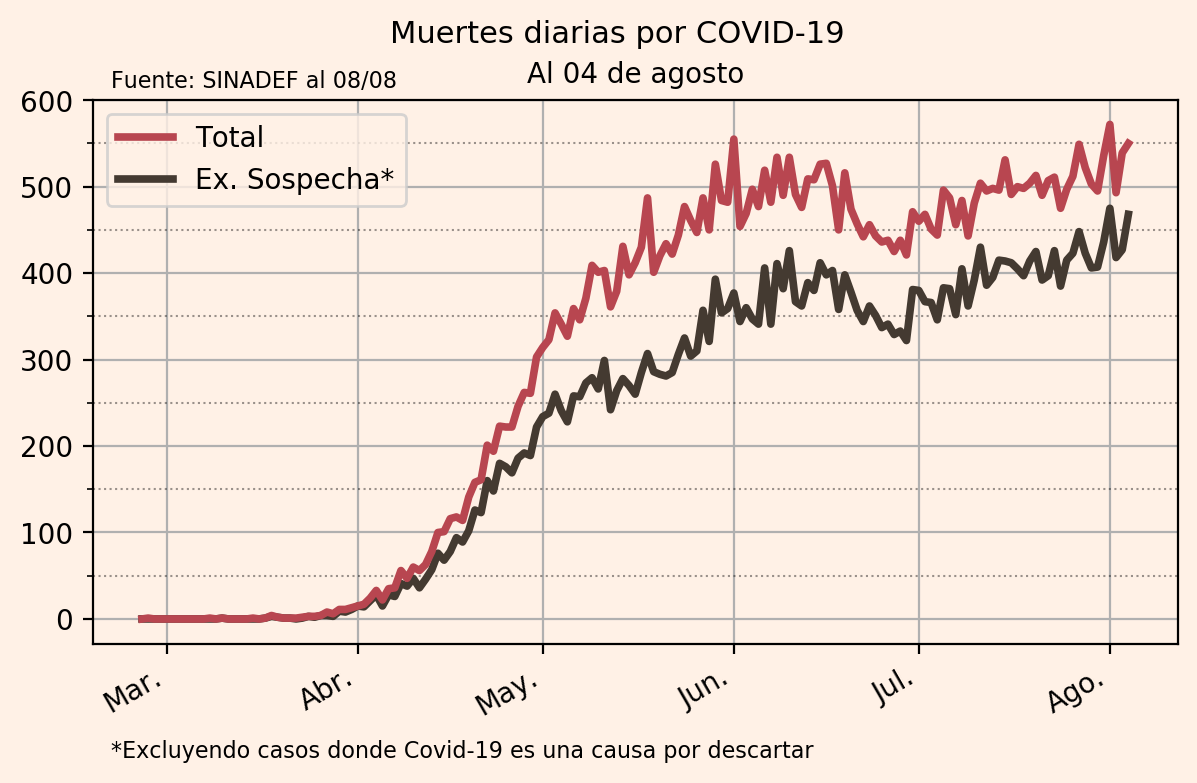

In [7]:
rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)


plt.plot(df_casos['FECHA'], df_casos['COVID'],color=(184/255, 70/255, 80/255),linewidth=2.75, label='Total', zorder=3);
plt.plot(df_casos['FECHA'], df_casos['COVID_CONF'],color=(68/255, 58/255, 49/255),linewidth=2.75, label='Ex. Sospecha*', zorder=2);
plt.gcf().autofmt_xdate()

plt.legend(loc=2)
plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)
plt.grid(zorder=0)
plt.title(mensaje_1, size=10)
plt.suptitle('Muertes diarias por COVID-19', size=11)

maximo = df_casos['COVID'].max()
fecha_ini = '21-02-2020'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.11, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '23-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.11, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), -140, '*Excluyendo casos donde Covid-19 es una causa por descartar',
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

plt.gca().yaxis.set_major_locator(MultipleLocator(100))
plt.gca().yaxis.set_minor_locator(MultipleLocator(50))
# plt.grid(zorder=2, alpha=0.8,linestyle=':',color='k',which='major')
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)


plt.show()

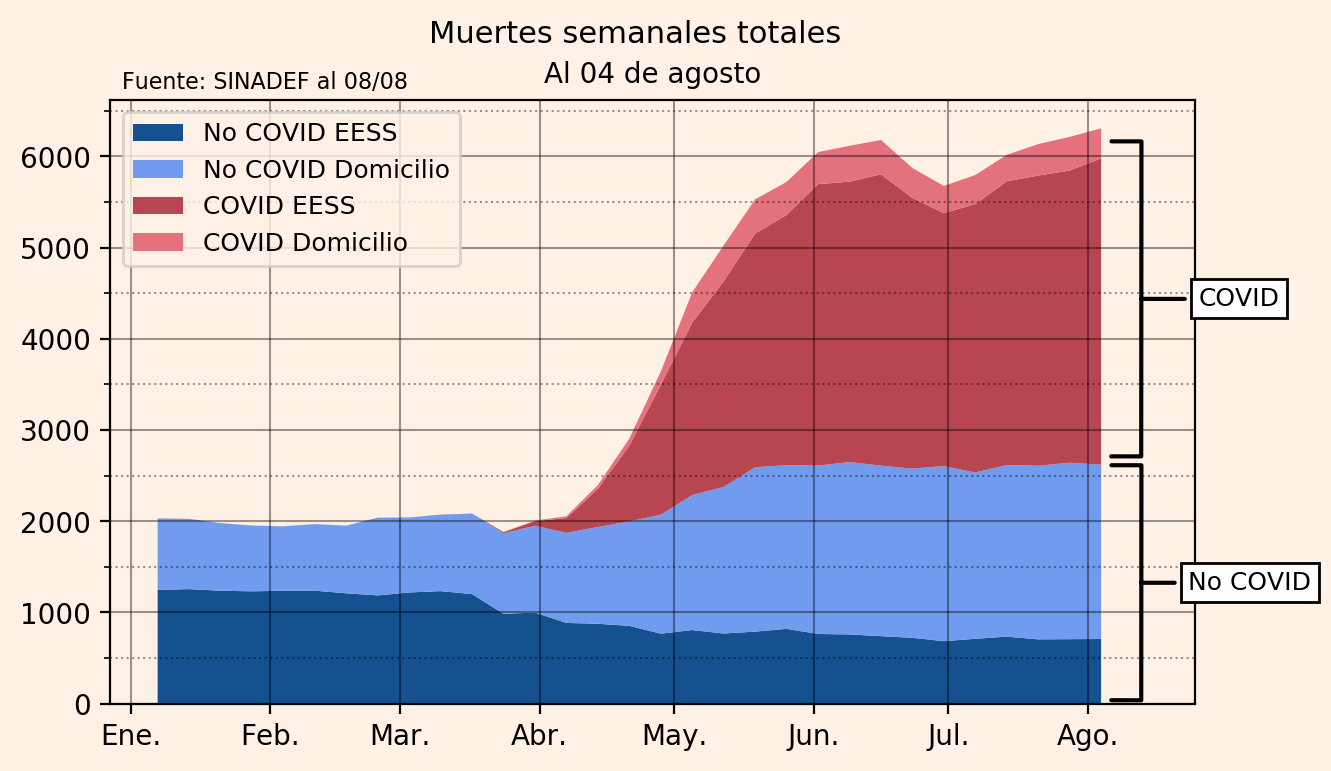

In [8]:
rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)

plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)

plt.title(mensaje_1, size=10)
plt.suptitle('Muertes semanales totales', size=11)
lab=["No COVID EESS", "No COVID Domicilio", "COVID EESS", "COVID Domicilio"]
plt.stackplot(df_casos_weekly['FECHA'], 
              df_casos_weekly['EXCOVID_EESS'], df_casos_weekly['EXCOVID_DOMICILIO'], 
              df_casos_weekly['COVID_EESS'], df_casos_weekly['COVID_DOMICILIO'], 
              labels=lab , zorder=0, colors =[(21/255, 81/255, 143/255), (112/255, 155/255, 238/255),  (184/255, 70/255, 80/255), (227/255, 114/255, 124/255)])
plt.legend(loc=2, prop={'size': 9})

# index = len(df_casos_weekly)-1
# maximo = 1.05*(df_casos_weekly['EXCOVID_EESS'][index] + df_casos_weekly['EXCOVID_DOMICILIO'][index] + df_casos_weekly['COVID_EESS'][index] +df_casos_weekly['COVID_DOMICILIO'][index])

maximo = (max(df_casos_weekly['EXCOVID_EESS'] + df_casos_weekly['EXCOVID_DOMICILIO'] + df_casos_weekly['COVID_EESS'] + df_casos_weekly['COVID_DOMICILIO']))

fecha_ini = '30-12-2019'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.1, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '29-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.1, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.xlim(right=df_casos_weekly['FECHA'][len(df_casos_weekly)-1]+datetime.timedelta(days=21))

# Here is the label and arrow code of interest
plt.annotate('COVID', xy=(0.945, 0.67), xytext=(1.04, 0.65), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=1.2', lw=1.5))

# Here is the label and arrow code of interest
plt.annotate('No COVID', xy=(0.945, 0.20), xytext=(1.05, 0.18), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=4.7, lengthB=1.2', lw=1.5))

#plt.gca().set_yticks(minor=True)
plt.gca().yaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_minor_locator(MultipleLocator(500))
plt.grid(zorder=2, alpha=0.4,linestyle='-',color='k',which='major', linewidth=0.75)
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)

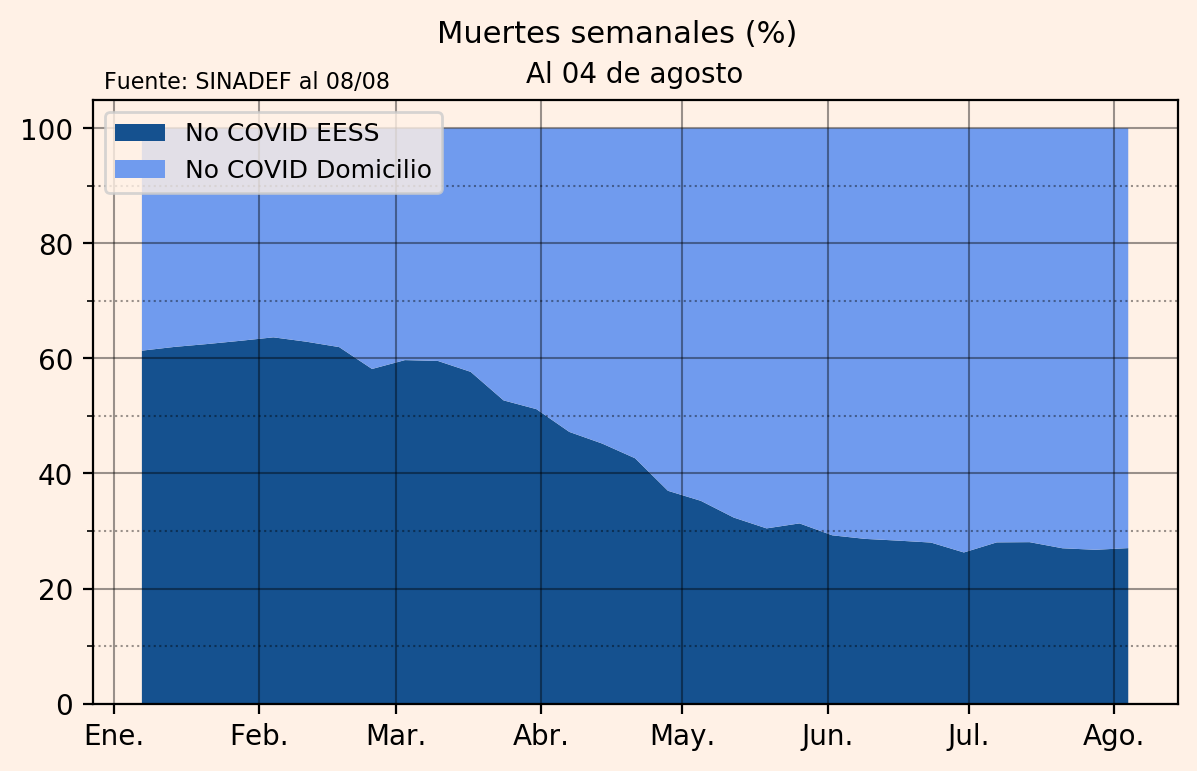

In [9]:
from matplotlib.ticker import MultipleLocator
rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)

plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)

plt.title(mensaje_1, size=10)
plt.suptitle('Muertes semanales (%)', size=11)
lab=["No COVID EESS", "No COVID Domicilio"]

plt.stackplot(df_casos_weekly['FECHA'], 
              df_casos_weekly['EXCOVID_EESS']/df_casos_weekly['EXCOVID']*100, df_casos_weekly['EXCOVID_DOMICILIO']/df_casos_weekly['EXCOVID']*100,  
              labels=lab , zorder=0, colors =[(21/255, 81/255, 143/255), (112/255, 155/255, 238/255)])
plt.legend(loc=2, prop={'size': 9})

index = len(df_casos_weekly)-1
maximo = 1.05*(df_casos_weekly['EXCOVID_EESS'][index] + df_casos_weekly['EXCOVID_DOMICILIO'][index] + df_casos_weekly['COVID_EESS'][index] +df_casos_weekly['COVID_DOMICILIO'][index])
fecha_ini = '30-12-2019'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), 110, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '19-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), 110, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.gca().yaxis.set_major_locator(MultipleLocator(20))
plt.gca().yaxis.set_minor_locator(MultipleLocator(10))
plt.grid(zorder=2, alpha=0.4,linestyle='-',color='k',which='major', linewidth=0.75)
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)

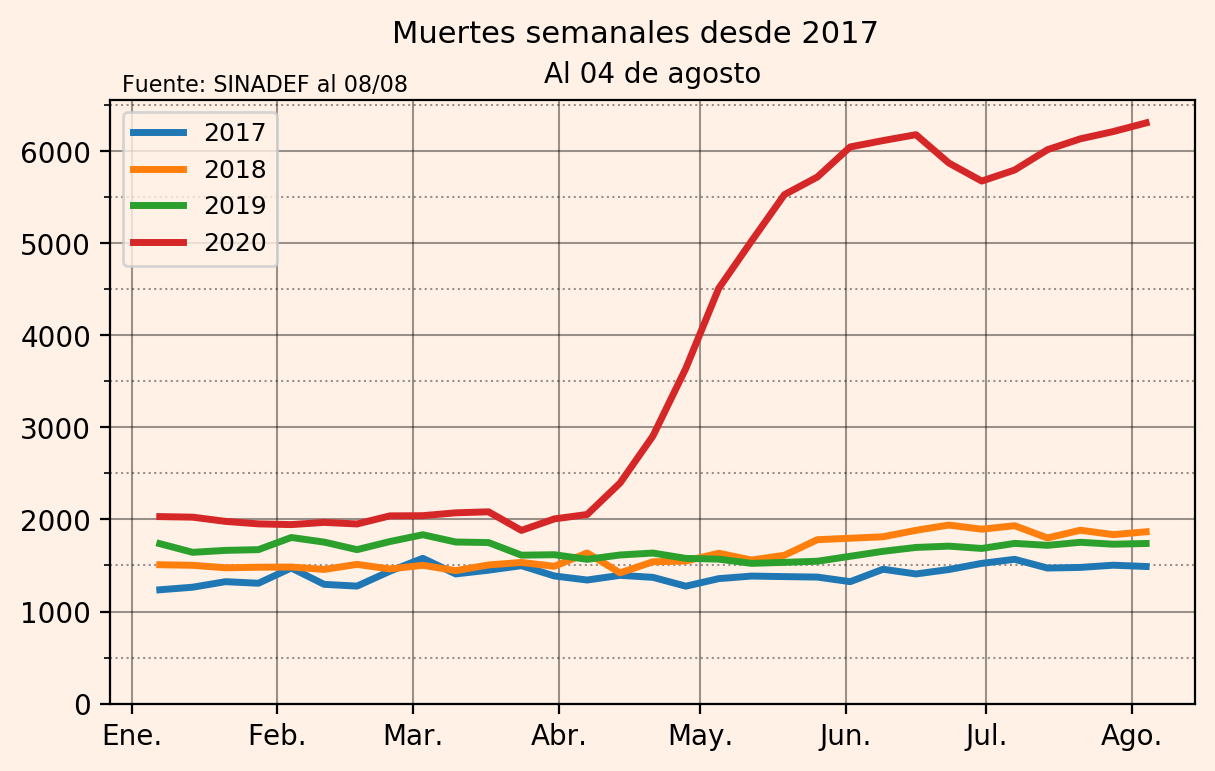

In [10]:

#plt.axis([1, 28, 0, 8000])



from matplotlib.ticker import MultipleLocator
rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)

plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)

plt.title(mensaje_1, size=10)
plt.suptitle('Muertes semanales desde 2017', size=11)
lab=["No COVID EESS", "No COVID Domicilio"]

for año in ['2017','2018','2019']:
    plt.plot(df_casos_weekly['FECHA'], df_casos_weekly['EXCOVID_'+año], label=año,linewidth=2.5);
plt.plot(df_casos_weekly['FECHA'], df_casos_weekly['EXCOVID']+df_casos_weekly['COVID'], label='2020',linewidth=2.5);
plt.legend(loc=2, prop={'size': 9})

fecha_ini = '30-12-2019'
maximo = max(df_casos_weekly['EXCOVID']+df_casos_weekly['COVID'])
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.085, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '19-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.085, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.ylim(bottom=0)
plt.gca().yaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_minor_locator(MultipleLocator(500))
plt.grid(zorder=2, alpha=0.4,linestyle='-',color='k',which='major', linewidth=0.75)
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)

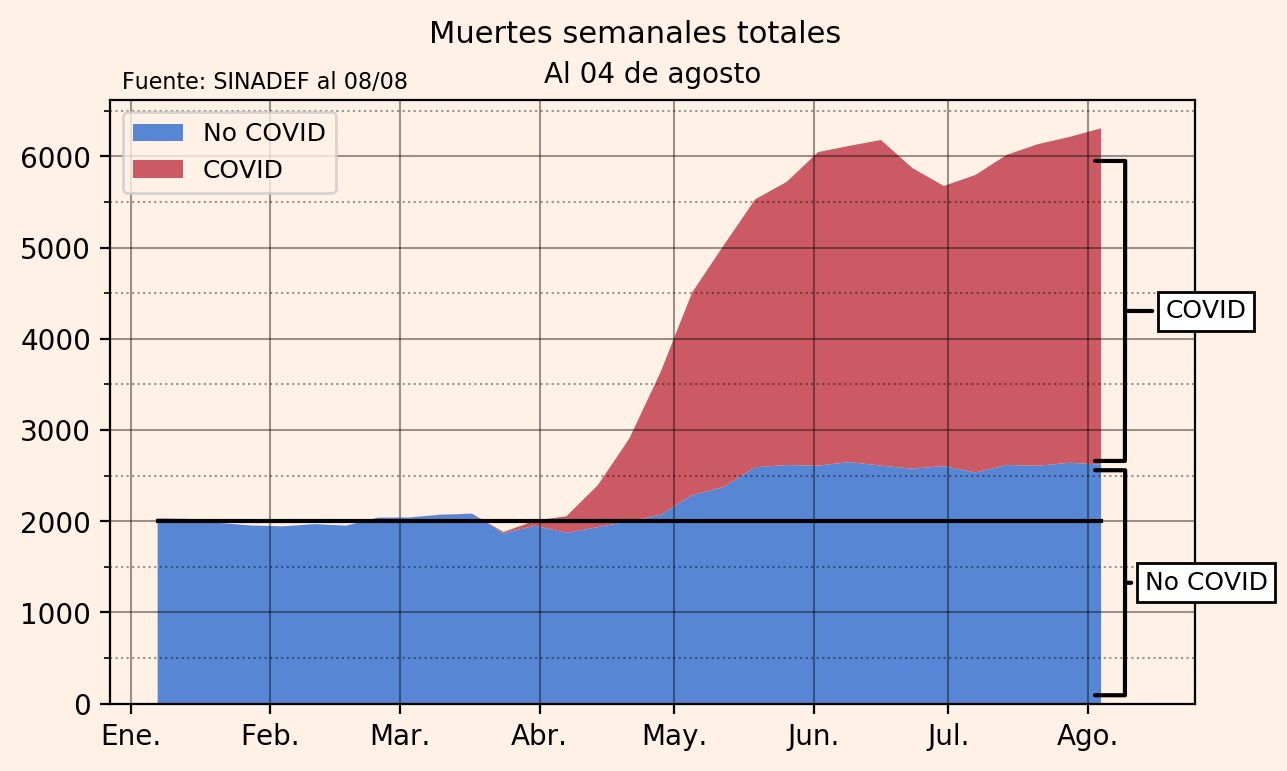

In [11]:
rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)

plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)

plt.title(mensaje_1, size=10)
plt.suptitle('Muertes semanales totales', size=11)
lab=["No COVID", "COVID"]
plt.stackplot(df_casos_weekly['FECHA'], 
              df_casos_weekly['EXCOVID_EESS'] + df_casos_weekly['EXCOVID_DOMICILIO'], 
              df_casos_weekly['COVID_EESS'] + df_casos_weekly['COVID_DOMICILIO'], 
              labels=lab , zorder=0, colors =[(87/255, 135/255, 212/255),  (204/255, 90/255, 100/255)])
plt.legend(loc=2, prop={'size': 9})

plt.plot(df_casos_weekly['FECHA'], 2000*np.ones(len(df_casos_weekly)),color='k')

# index = len(df_casos_weekly)-1
# maximo = 1.05*(df_casos_weekly['EXCOVID_EESS'][index] + df_casos_weekly['EXCOVID_DOMICILIO'][index] + df_casos_weekly['COVID_EESS'][index] +df_casos_weekly['COVID_DOMICILIO'][index])

maximo = (max(df_casos_weekly['EXCOVID_EESS'] + df_casos_weekly['EXCOVID_DOMICILIO'] + df_casos_weekly['COVID_EESS'] + df_casos_weekly['COVID_DOMICILIO']))

fecha_ini = '30-12-2019'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.1, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '29-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.1, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.xlim(right=df_casos_weekly['FECHA'][len(df_casos_weekly)-1]+datetime.timedelta(days=21))

# Here is the label and arrow code of interest
plt.annotate('COVID', xy=(0.93, 0.65), xytext=(1.01, 0.63), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1.2', lw=1.5))

# Here is the label and arrow code of interest
plt.annotate('No COVID', xy=(0.93, 0.20), xytext=(1.01, 0.18), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=4.5, lengthB=1.2', lw=1.5))

#plt.gca().set_yticks(minor=True)
plt.gca().yaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_minor_locator(MultipleLocator(500))
plt.grid(zorder=2, alpha=0.4,linestyle='-',color='k',which='major', linewidth=0.75)
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


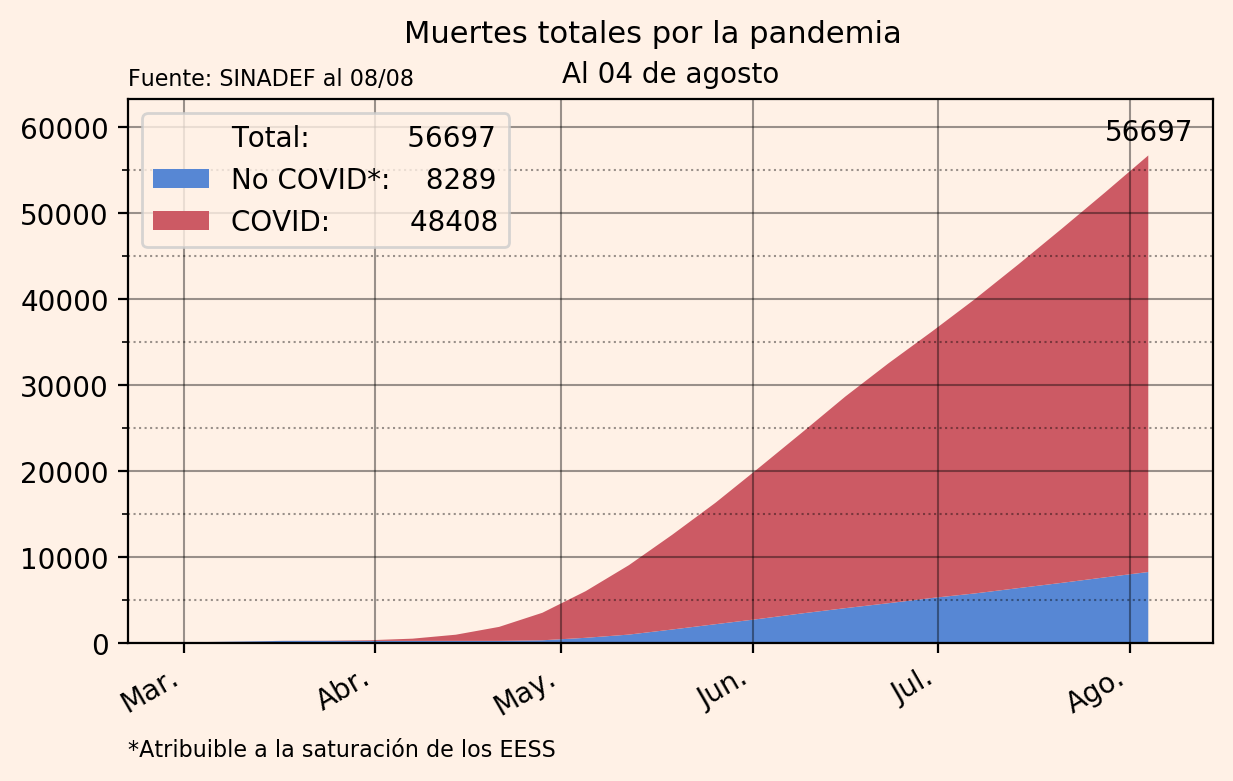

In [12]:
df_casos_weekly['COVID_acumulado'] = np.cumsum(df_casos_weekly['COVID'])
df_casos_weekly['COVID_acumulado'][len(df_casos_weekly)-1] -= 2
 
df_casos_weekly['EXCOVID_mean'] = df_casos_weekly['EXCOVID'] - 2000
df_casos_weekly['EXCOVID_mean'][df_casos_weekly['EXCOVID_mean']<0] = 0

df_casos_weekly['EXCOVID_acumulado'] = np.cumsum(df_casos_weekly['EXCOVID_mean'])

rcParams['figure.figsize'] = 7, 4
mpl.rcParams['figure.dpi'] = 200

locale.setlocale(locale.LC_TIME, "es_PE") # swedish

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
months = mdates.MonthLocator()

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_locator(months)

maximo = df_casos_weekly['COVID_acumulado'].max() + df_casos_weekly['EXCOVID_acumulado'].max()

plt.title(mensaje_1, size=10)
plt.suptitle('Muertes semanales totales', size=11)
lab=["No COVID*:    " + str(df_casos_weekly['EXCOVID_acumulado'].max()), "COVID:         " + str(df_casos_weekly['COVID_acumulado'].max())]
plt.stackplot(df_casos_weekly['FECHA'], 
              df_casos_weekly['EXCOVID_acumulado'], 
              df_casos_weekly['COVID_acumulado'], 
              labels=lab , zorder=0, colors =[(87/255, 135/255, 212/255),  (204/255, 90/255, 100/255)])
plt.plot([], [], ' ', label="Total:           " + str(maximo))
plt.legend(loc=2, prop={'size': 9})

plt.gcf().autofmt_xdate()

plt.rcParams['axes.facecolor'] = (255/255, 241/255, 230/255)
plt.rcParams['figure.facecolor'] = (255/255, 241/255, 230/255)
plt.grid(zorder=0)
plt.title(mensaje_1, size=10)
plt.suptitle('Muertes totales por la pandemia', size=11)


fecha_ini = '21-02-2020'
plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), maximo*1.18, mensaje_2,
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

if firma:
    fecha_firm = '26-06-2020'
    plt.text(fechas.strptime(fecha_firm, "%d-%m-%Y"), maximo*1.18, 'by @not_ccd',
             horizontalalignment='left',
             verticalalignment='top',
             multialignment='left', size=8);

plt.text(fechas.strptime(fecha_ini, "%d-%m-%Y"), -11000, '*Atribuible a la saturación de los EESS',
         horizontalalignment='left',
         verticalalignment='top',
         multialignment='left', size=8);

plt.text(df_casos_weekly['FECHA'][len(df_casos_weekly)-2], maximo*1.03, maximo, zorder=3)
plt.ylim(top=maximo*1.115)
plt.xlim(left=fechas.strptime(fecha_ini, "%d-%m-%Y"))

#plt.gca().set_yticks(minor=True)
plt.gca().yaxis.set_major_locator(MultipleLocator(10000))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(zorder=2, alpha=0.4,linestyle='-',color='k',which='major', linewidth=0.75)
plt.grid(zorder=2, alpha=0.4,linestyle=':',color='k',which='minor', linewidth=0.75)


plt.legend(loc=2)

plt.show()

In [13]:
df_casos_weekly['EXCOVID_acumulado']

0       31
1       55
2       55
3       55
4       55
5       55
6       55
7       94
8      134
9      204
10     285
11     285
12     285
13     285
14     285
15     285
16     356
17     643
18    1018
19    1609
20    2224
21    2833
22    3481
23    4090
24    4666
25    5270
26    5804
27    6420
28    7028
29    7669
30    8289
Name: EXCOVID_acumulado, dtype: int64

In [14]:
df_casos_weekly['EXCOVID']

0     2031
1     2024
2     1979
3     1952
4     1943
5     1968
6     1951
7     2039
8     2040
9     2070
10    2081
11    1867
12    1950
13    1872
14    1936
15    1998
16    2071
17    2287
18    2375
19    2591
20    2615
21    2609
22    2648
23    2609
24    2576
25    2604
26    2534
27    2616
28    2608
29    2641
30    2620
Name: EXCOVID, dtype: int64